# 6章 アルゴリズムチェーンとパイプライン

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

scaler = MinMaxScaler().fit(x_train)

x_train_scaled = scaler.transform(x_train)

svm = SVC()
svm.fit(x_train_scaled, y_train)

x_test_scaled = scaler.transform(x_test)
print("Test score: {:.2f}".format(svm.score(x_test_scaled, y_test)))

Test score: 0.95


## 6.1 前処理を行う際のパラメータ選択

In [3]:
from sklearn.model_selection import GridSearchCV

param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(x_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(x_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


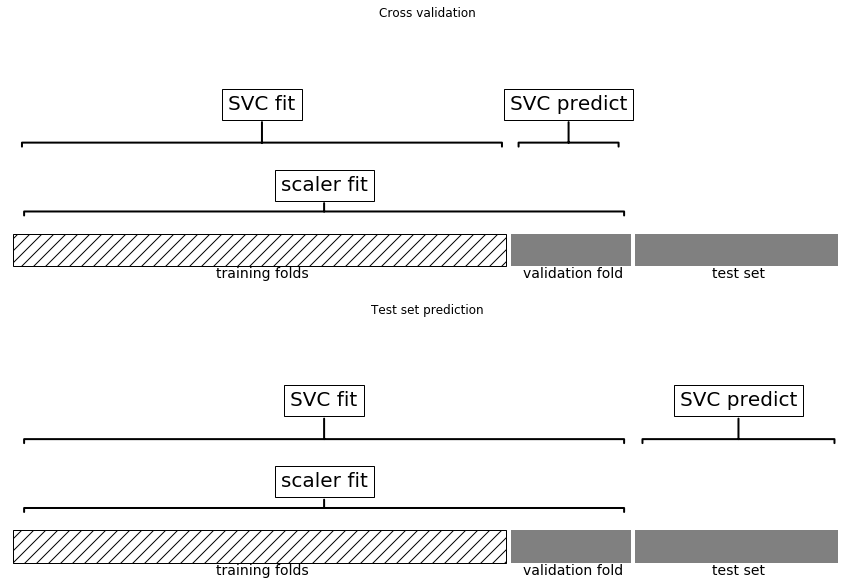

In [6]:
%matplotlib inline
import mglearn
mglearn.plots.plot_improper_processing()

## 6.2 パイプラインの構築

In [7]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svm", SVC())
])

pipe.fit(x_train, y_train)
print("Test score: {:.2f}".format(pipe.score(x_test, y_test)))

Test score: 0.95


## 6.3 パイプラインを用いたグリッドサーチ

In [8]:
param_grid = {"svm__C": [0.001, 0.01, 0.1, 1, 10, 100], "svm__gamma": [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(x_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(x_test, y_test)))
print("Best parameters:{}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters:{'svm__C': 1, 'svm__gamma': 1}


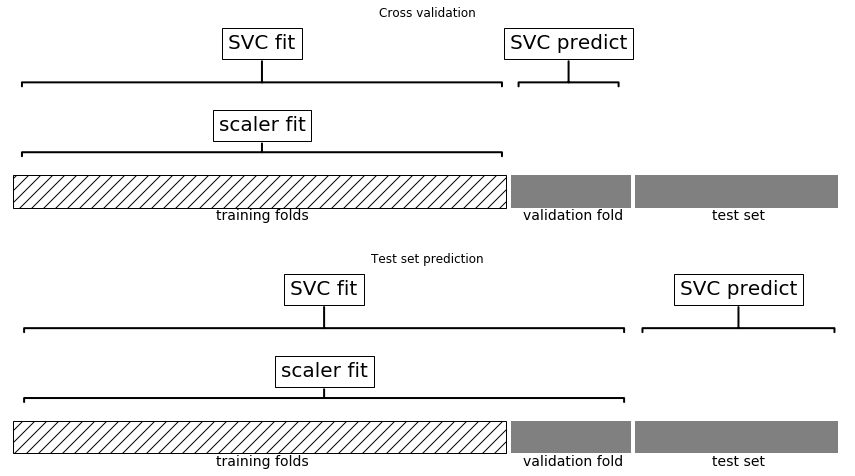

In [9]:
mglearn.plots.plot_proper_processing()

In [11]:
import numpy as np

rnd = np.random.RandomState(seed=0)
x = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(x, y)
x_selected = select.transform(x)
print("x_selected.shape: {}".format(x_selected.shape))

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(np.mean(cross_val_score(Ridge(), x_selected, y, cv=5))))

x_selected.shape: (100, 500)
Cross-validation accuracy (cv only on ridge): 0.91


In [12]:
pipe = Pipeline([
    ("select", SelectPercentile(score_func=f_regression, percentile=5)),
    ("ridge", Ridge())
])
print("Cross-validation accuracy (pipeline): {:.2f}".format(np.mean(cross_val_score(pipe, x, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


## 6.4 汎用パイプラインインターフェイス
### 6.4.1 make_pipelineによる簡便なパイプライン生成

In [13]:
from sklearn.pipeline import make_pipeline

pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
pipe.steps

[('standardscaler-1',
  StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('pca',
  PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('standardscaler-2',
  StandardScaler(copy=True, with_mean=True, with_std=True))]

### 6.4.2 ステップ属性へのアクセス

In [15]:
pipe.fit(cancer.data)

components = pipe.named_steps["pca"].components_

components.shape

(2, 30)

### 6.4.3 GridSearchCV内のパイプラインの属性へのアクセス

In [16]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

param_grid = {"logisticregression__C": [0.01, 0.1, 1, 10, 100]}

x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(x_train, y_train)

grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [17]:
grid.best_estimator_.named_steps["logisticregression"]

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
grid.best_estimator_.named_steps["logisticregression"].coef_

array([[-0.38856355, -0.37529972, -0.37624793, -0.39649439, -0.11519359,
         0.01709608, -0.3550729 , -0.38995414, -0.05780518,  0.20879795,
        -0.49487753, -0.0036321 , -0.37122718, -0.38337777, -0.04488715,
         0.19752816,  0.00424822, -0.04857196,  0.21023226,  0.22444999,
        -0.54669761, -0.52542026, -0.49881157, -0.51451071, -0.39256847,
        -0.12293451, -0.38827425, -0.4169485 , -0.32533663, -0.13926972]])

## 6.5 前処理ステップとモデルパラメータに対するグリッドサーチ

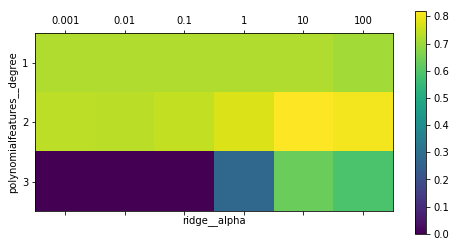

In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
boston = load_boston()
x_train, x_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

param_grid = {"polynomialfeatures__degree": [1, 2, 3], "ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(x_train, y_train)

plt.matshow(grid.cv_results_["mean_test_score"].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid["ridge__alpha"])), param_grid["ridge__alpha"])
plt.yticks(range(len(param_grid["polynomialfeatures__degree"])), param_grid["polynomialfeatures__degree"])
plt.colorbar()

In [28]:
print("Best Parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(x_test, y_test)))


Best Parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Test-set score: 0.77


In [29]:
param_grid = {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(x_train, y_train)
grid.score(x_test, y_test)

0.62717803817745799

## 6.6 グリッドサーチによるモデルの選択

In [30]:
pipe = Pipeline([("preprocessing", StandardScaler()), ("classifier", SVC())])
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {"classifier": [SVC()], "preprocessing": [StandardScaler(), None], "classifier__gamma": [0.001, 0.01, 0.1, 1, 10, 100], "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100]},
    {"classifier": [RandomForestClassifier(n_estimators=100)], "preprocessing": [None], "classifier__max_features": [1, 2, 3]}
]

x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, para)